## Generate the toy data and visualize

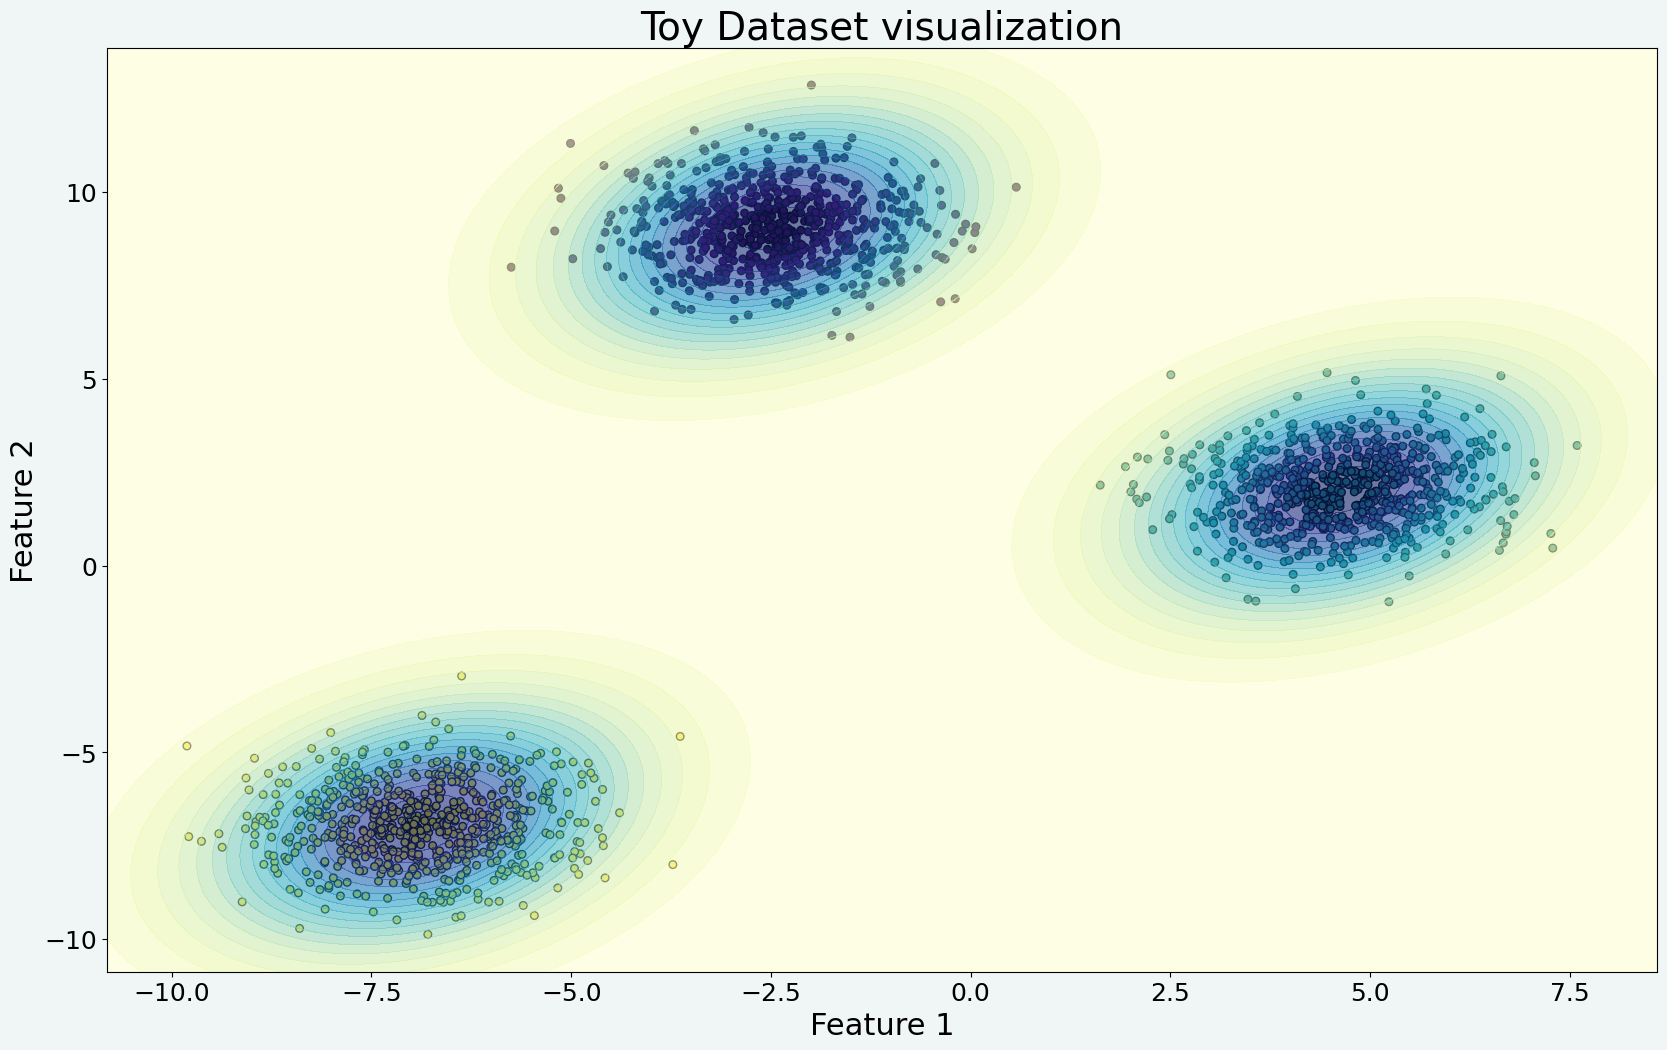

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.datasets import make_blobs
from scipy.stats import gaussian_kde

# Generate toy dataset with 3 spherical clusters
X, y_true = make_blobs(n_samples=2000, centers=3, cluster_std=1.0, random_state=42)

# Perform Kernel Density Estimation
kde = gaussian_kde(X.T)

# Create a grid over the data
x = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 300)
y = np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 300)
X_grid, Y_grid = np.meshgrid(x, y)
grid_coords = np.vstack([X_grid.ravel(), Y_grid.ravel()])

# Evaluate KDE on grid
Z = kde(grid_coords).reshape(X_grid.shape)

# Plot
plt.figure(figsize=(20, 12), facecolor='#f0f5f5')  # outer figure background
ax = plt.gca()
ax.set_facecolor('white')  # inner plot background set to white

plt.scatter(X[:, 0], X[:, 1], c=y_true, s=30, cmap='viridis', edgecolor='k')
plt.contourf(X_grid, Y_grid, Z, levels=20, cmap='YlGnBu', alpha=0.6)  # changed colormap
plt.title("Toy Dataset visualization", fontsize=28)
plt.xlabel("Feature 1", fontsize=22)
plt.ylabel("Feature 2", fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig("plots/Toy_data.png")
plt.show()

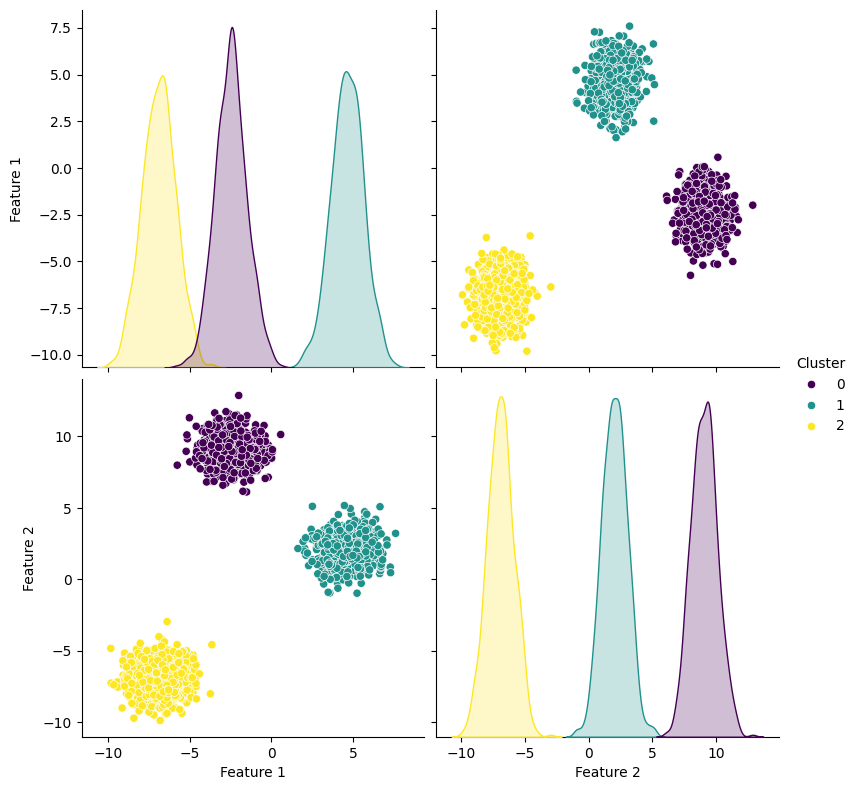

In [3]:
df = pd.DataFrame(X, columns=['Feature 1', 'Feature 2'])
df['Cluster'] = y_true

# Generate a Seaborn pairplot
sns.pairplot(df, hue='Cluster', palette='viridis', height=4, diag_kind='kde')
plt.show()

## View the data

In [4]:
df

,Feature 1,Feature 2,Cluster
0,4.511341,0.091321,1
1,5.181342,2.732325,1
2,3.288804,0.650712,1
3,-6.933532,-7.862413,2
4,-4.888074,-7.712171,2
...,...,...,...
1995,3.443996,2.417772,1
1996,-6.972571,-7.119612,2
1997,4.186630,3.425637,1
1998,-8.519111,-7.272581,2


## Save the data

In [6]:
df.to_csv("Data/Toy data for GMM.csv",index=False)

## Define the Model

In [7]:
import numpy as np

class GMM:
    def __init__(self, n_components=3, max_iter=100, tol=1e-6, random_state=None):
        """
        Initialize the Gaussian Mixture Model.

        Parameters:
        - n_components: Number of Gaussian components.
        - max_iter: Maximum number of EM iterations.
        - tol: Convergence threshold for log-likelihood.
        - random_state: Seed for random number generator.
        """
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state

    def _initialize_parameters(self, X):
        """
        Initialize the parameters: means, covariances, and weights.
        """
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape

        # Randomly select initial means from the data points
        indices = np.random.choice(n_samples, self.n_components, replace=False)
        self.means = X[indices]

        # Initialize all covariances to the sample covariance of the dataset
        self.covariances = np.array([np.cov(X, rowvar=False)] * self.n_components)

        # Initialize component weights uniformly
        self.weights = np.ones(self.n_components) / self.n_components

    def _gaussian(self, X, mean, cov):
        """
        Compute the multivariate Gaussian probability density function.

        Parameters:
        - X: Input data.
        - mean: Mean of the Gaussian.
        - cov: Covariance matrix of the Gaussian.
        """
        n = X.shape[1]  # Number of features
        diff = X - mean
        inv_cov = np.linalg.inv(cov)
        exponent = np.einsum('...k,kl,...l->...', diff, inv_cov, diff)
        denominator = np.sqrt((2 * np.pi) ** n * np.linalg.det(cov))
        return np.exp(-0.5 * exponent) / denominator

    def _e_step(self, X):
        """
        E-step: Calculate responsibilities using current parameters.
        """
        n_samples = X.shape[0]
        self.resp = np.zeros((n_samples, self.n_components))

        # Calculate weighted probabilities for each component
        for k in range(self.n_components):
            self.resp[:, k] = self.weights[k] * self._gaussian(X, self.means[k], self.covariances[k])

        # Normalize across components to get posterior probabilities
        self.resp /= self.resp.sum(axis=1, keepdims=True)

    def _m_step(self, X):
        """
        M-step: Update parameters using current responsibilities.
        """
        n_samples = X.shape[0]

        for k in range(self.n_components):
            resp_k = self.resp[:, k]
            total_resp = resp_k.sum()

            # Update weights
            self.weights[k] = total_resp / n_samples

            # Update means
            self.means[k] = (X * resp_k[:, np.newaxis]).sum(axis=0) / total_resp

            # Update covariances
            diff = X - self.means[k]
            weighted_diff = resp_k[:, np.newaxis] * diff
            self.covariances[k] = np.dot(weighted_diff.T, diff) / total_resp

    def fit(self, X):
        """
        Fit the GMM to the data using the EM algorithm.

        Parameters:
        - X: Input data array of shape (n_samples, n_features)
        """
        self._initialize_parameters(X)
        log_likelihood = None

        for _ in range(self.max_iter):
            self._e_step(X)
            self._m_step(X)

            # Compute log-likelihood
            ll = np.sum(np.log(np.sum([
                self.weights[k] * self._gaussian(X, self.means[k], self.covariances[k])
                for k in range(self.n_components)
            ], axis=0)))

            # Check convergence
            if log_likelihood is not None and np.abs(ll - log_likelihood) < self.tol:
                break
            log_likelihood = ll

    def predict(self, X):
        """
        Predict the component assignments for the input data.

        Parameters:
        - X: Input data.

        Returns:
        - Component labels (integers from 0 to n_components-1).
        """
        responsibilities = np.array([
            self.weights[k] * self._gaussian(X, self.means[k], self.covariances[k])
            for k in range(self.n_components)
        ]).T

        return np.argmax(responsibilities, axis=1)

    def predict_proba(self, X):
        """
        Predict the posterior probabilities (responsibilities) for each component.

        Parameters:
        - X: Input data.

        Returns:
        - Array of shape (n_samples, n_components) with responsibilities.
        """
        responsibilities = np.zeros((X.shape[0], self.n_components))
        for k in range(self.n_components):
            responsibilities[:, k] = self.weights[k] * self._gaussian(X, self.means[k], self.covariances[k])

        # Normalize to get probabilities
        responsibilities /= responsibilities.sum(axis=1, keepdims=True)
        return responsibilities


### Fit the model

In [8]:
gmm = GMM(n_components=3, max_iter=100, tol=1e-4, random_state=42)
gmm.fit(X)
pred_labels = gmm.predict(X)

In [9]:
gmm.means

array([[-2.47236979,  9.05024643],
       [ 4.63302079,  2.04133634],
       [-6.88074384, -6.90211374]])

In [10]:
gmm.covariances

array([[[ 0.91584409, -0.02840355],
        [-0.02840355,  1.02181707]],

       [[ 0.9698756 ,  0.05579388],
        [ 0.05579388,  0.97003198]],

       [[ 1.02638717,  0.03302892],
        [ 0.03302892,  1.05511175]]])

### Visualize the means 

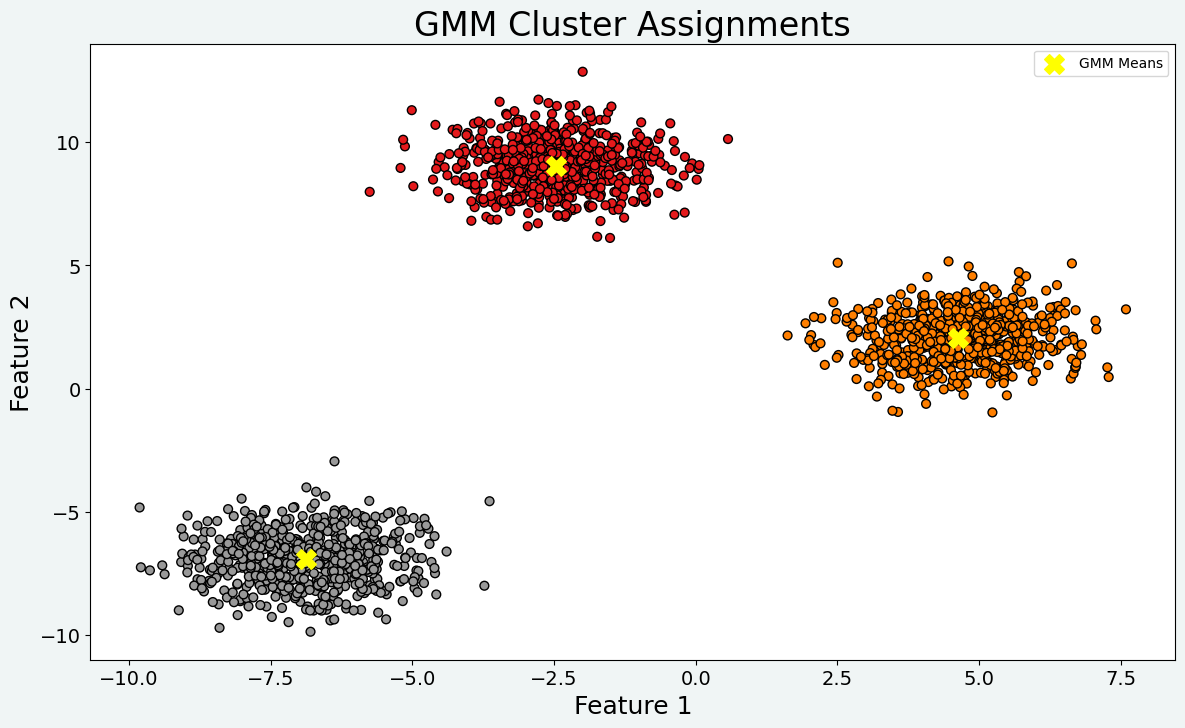

In [12]:
import matplotlib.pyplot as plt

# Predict cluster labels from the fitted GMM
pred_labels = gmm.predict(X)

# Plot the predicted clusters
plt.figure(figsize=(14, 8), facecolor='#f0f5f5')
ax = plt.gca()
ax.set_facecolor('white')

plt.scatter(X[:, 0], X[:, 1], c=pred_labels, cmap='Set1', s=40, edgecolor='k')
plt.scatter(gmm.means[:, 0], gmm.means[:, 1], c='yellow', s=200, marker='X', label='GMM Means')

plt.title("GMM Cluster Assignments", fontsize=24)
plt.xlabel("Feature 1", fontsize=18)
plt.ylabel("Feature 2", fontsize=18)
plt.legend()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("plots/Cluster_means.png")
plt.show()


### View Covariance Ellipses

In [16]:
from matplotlib.patches import Ellipse

def plot_gmm_ellipses(gmm, X, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 8), facecolor='#f0f5f5')
        ax.set_facecolor('white')
    
    pred = gmm.predict(X)
    ax.scatter(X[:, 0], X[:, 1], c=pred, cmap='Set1', s=40, edgecolor='k', alpha=0.5)
    
    for pos, covar, w in zip(gmm.means, gmm.covariances, gmm.weights):
        if covar.ndim == 1:  # diagonal covariance
            cov_matrix = np.diag(covar)
        else:
            cov_matrix = covar
        v, w_ = np.linalg.eigh(cov_matrix)
        angle = np.arctan2(w_[1, 0], w_[0, 0])
        angle = np.degrees(angle)
        for j in range(1, 4):  # 1σ, 2σ, 3σ
            ell = Ellipse(pos, width=2 * j * np.sqrt(v[0]), height=2 * j * np.sqrt(v[1]),
                          angle=angle, edgecolor='k', facecolor='none', linestyle='--', linewidth=1)
            ax.add_patch(ell)
    
    ax.set_title("GMM Clusters with Covariance Ellipses", fontsize=24)
    ax.set_xlabel("Feature 1", fontsize=18)
    ax.set_ylabel("Feature 2", fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig("plots/Cluster_Covariances.png")
    plt.show()


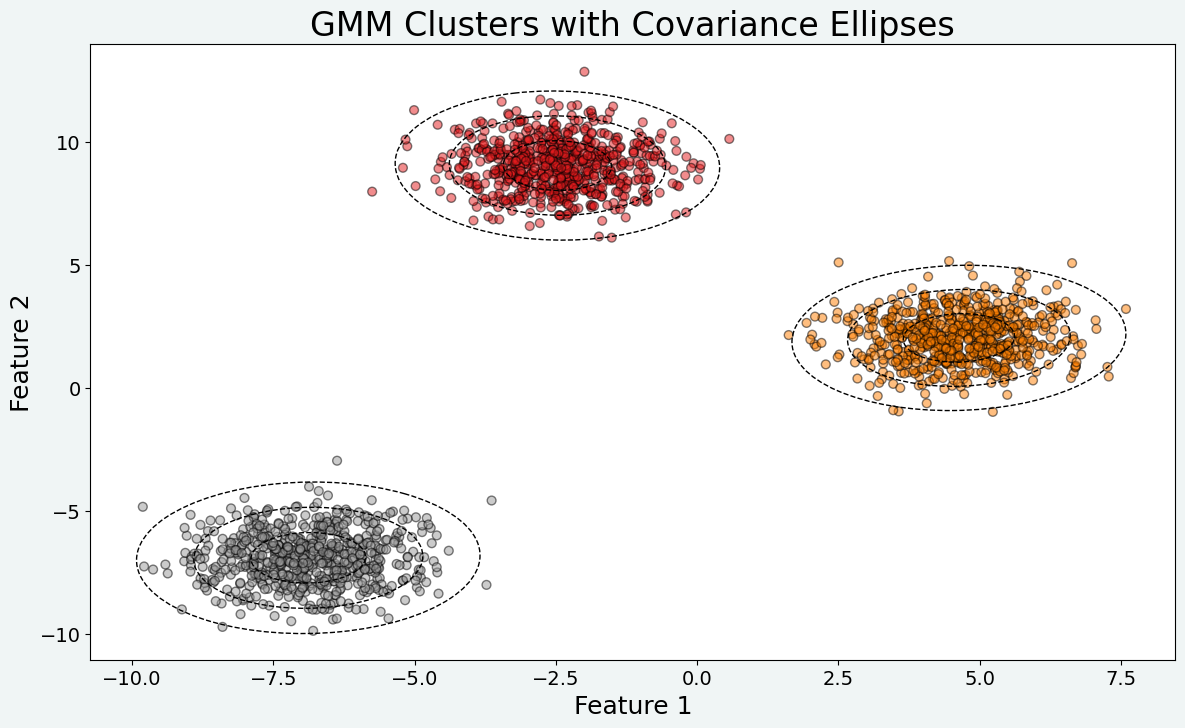

In [17]:
plot_gmm_ellipses(gmm, X, ax=None)